In [1]:
from sklearn import neural_network
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import cross_validate
from matplotlib import pyplot as plt

## Loading data

In [2]:
with open('../../../data/mnist-csv-format/mnist_train.csv') as tr:
    training = np.loadtxt(tr, delimiter=',', dtype=int)
    training_samples = training[:, 1:]
    training_labels = training[:, 0]

In [3]:
with open('../../../data/mnist-csv-format/mnist_test.csv') as ts:
    tests = np.loadtxt(ts, delimiter=',', dtype=int)
    test_samples = tests[:, 1:]
    test_labels = tests[:, 0]

## Optimizing number of neurons in a single hidden layer

Trying out values from 1 to 100, taking into account every multiple of 10

In [4]:
neurons_scores = []
for i in range(0,101, 10):
    if i == 0:
        j = 1
    else:
        j = i
    mlp = neural_network.MLPClassifier(
        hidden_layer_sizes=(j,),
    )
    mlp.fit(training_samples, training_labels)
    neurons_scores.append(accuracy_score(test_labels, mlp.predict(test_samples)))

neurons_optimized = np.argmax(np.array(neurons_scores)) * 10
if neurons_optimized == 0: neurons_optimized = 1

print(f"OPTIMIZED NEURONS: {neurons_optimized}" )
print(neurons_scores)

C:\Users\tlucz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


OPTIMIZED NEURONS: 100
[0.1134, 0.8529, 0.9313, 0.9403, 0.9413, 0.9548, 0.9522, 0.9605, 0.9613, 0.9629, 0.9639]


In case of MNIST dataset accuracy grows as we put in more neurons - 100 neuron single layer MLP produces satisfactory results, while scoring test partition 

## Optimizing learning rate

Another parameter to optimize is the initial learning rate, which according to task description typically takes values from 0.001 to 0.1.

In [5]:
rates_scores = []
learning_rates = np.linspace(0.001,0.1,10)
for rate in learning_rates:
    mlp = neural_network.MLPClassifier(
        hidden_layer_sizes=(100,),
        learning_rate_init=rate,
    )
    mlp.fit(training_samples, training_labels)
    rates_scores.append(accuracy_score(test_labels, mlp.predict(test_samples)))

optimal_learning_rate = learning_rates[np.argmax(rates_scores)]
print(f"Optimal LR: {optimal_learning_rate}")
print(rates_scores)

Optimal LR: 0.001
[0.9652, 0.5083, 0.0976, 0.1181, 0.1153, 0.1023, 0.1139, 0.1035, 0.101, 0.0958]


Accuracy falls rapidly the greater learning rate is. Therefore we'll stick with 0.001

## Optimizing max iterations

Sklearn framework provides built-in feature to perform epoch optimization. We set *max_iter* to an arbitrary large number to bypass default limit of 200 epochs. By setting *early_stopping* property to True, 10% of training values are set aside for validation, and convergence is achieved whenever validation score doesn't improve by more than *tol* for *n_iter_no_change* consecutive epochs:

In [27]:
mlp = neural_network.MLPClassifier(
    hidden_layer_sizes=(100,),
    learning_rate_init=0.001,
    max_iter=5000,
    early_stopping=True,
    validation_fraction=0.1,
    tol=1e-4,
    n_iter_no_change=10,
)
mlp.fit(training_samples, training_labels)


MLPClassifier(early_stopping=True, max_iter=5000)

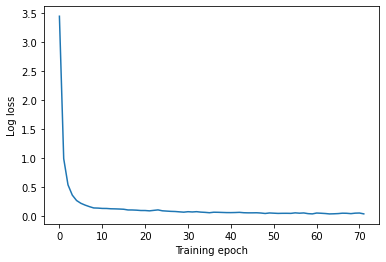

In [32]:
plt.plot(mlp.loss_curve_)
plt.xlabel("Training epoch")
plt.ylabel("Log loss")
plt.savefig("mlp_loss.png")
plt.show()

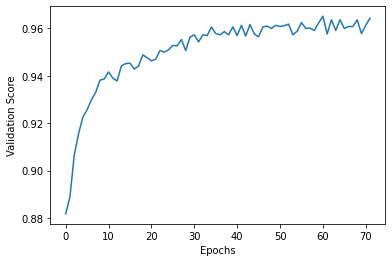

In [33]:
plt.plot(mlp.validation_scores_)
plt.xlabel("Epochs")
plt.ylabel("Validation Score")
plt.savefig("mlp_valscore.png")
plt.show()

## Random State initialization and choosing the best model 

Checking model's performace for 5 random states, getting the best estimator for each using cross validation and scoring it with test data:

In [36]:
test_scores = []
for i in range(5):
    mlp = neural_network.MLPClassifier(
        hidden_layer_sizes=(100,),
        learning_rate_init=0.001,
        max_iter=5000,
        early_stopping=True,
        validation_fraction=0.1,
        tol=1e-4,
        n_iter_no_change=10,
        random_state=i,
    )
    cv_results = cross_validate(
        mlp, 
        training_samples, 
        training_labels,
        scoring="accuracy",
        return_estimator=True
    )
    estimator_to_return = np.argmax(cv_results['test_score'])
    estimator = cv_results['estimator'][estimator_to_return]
    test_scores.append(accuracy_score(test_labels, estimator.predict(test_samples)))

print(f"Optimal random state: {np.argmax(test_scores)}")

Optimal random state: 0


In [37]:
print(f"Maximal accuracy on test set: {test_scores[0]}")

Maximal accuracy on test set: 0.9652


Optimized parameters for MLP while training on MNIST dataset are as follows:

| Parameter | Value |
| --------- | ----- |
| No. of neurons | 100 |
| Learning rate | 0.001 |
| Max iterations | Early stopping |
| Random state | 0 |

Maximal accuracy achieved was equal to 96,52%